# Notebook C: Evaluation of ML Algorithms for Rate Prediction of Syngas Fermentation

### Setup imports

In [2]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.preprocessing, sklearn.neural_network, sklearn.svm, sklearn.ensemble
import scipy.stats
import matplotlib.pyplot as plt

### Load data that was generated in notebook A

In [3]:
rates_df = pd.read_csv(f'../data/rates_data.csv')
print(f'Shape of the rates data: {rates_df.shape[0]} rows by {rates_df.shape[1]} columns')

Shape of the rates data: 836 rows by 18 columns


### Create train and test sets

In [4]:
train_data = rates_df[rates_df.composition.isin([1,2,3,4,5,6,7])]
test_data = rates_df[rates_df.composition.isin([8,9,10])]
print(f'Shape of the training data: {train_data.shape[0]} rows by {train_data.shape[1]} columns')
print(f'Shape of the testing data: {test_data.shape[0]} rows by {test_data.shape[1]} columns')

Shape of the training data: 657 rows by 18 columns
Shape of the testing data: 179 rows by 18 columns


### Define a function that generates the input and output arrays for scikit learn's API

In [5]:
def get_X_y_arrays(data):
    
    # prevent set with copy error
    data_copy = data.copy()
    
    # ML input
    X = data_copy [[
        'biomass (g/L)', 'ethanol (mM)', 'acetate (mM)', 'butanol (mM)', 
         'butyrate (mM)', 'N2', 'CO', 'CO2', 'H2', 'flow rate (mL/min)'
    ]]
    
    # ML output
    y = data_copy [[
        'biomass rate', 'ethanol rate', 'acetate rate', 'butanol rate', 'butyrate rate'
    ]]
 
    return np.array(X), np.array(y)

### Split data into ML input and output

In [6]:
X_train, y_train = get_X_y_arrays(train_data)
X_test, y_test = get_X_y_arrays(test_data)

print(f'Shape of the train X array: {X_train.shape[0]} rows by {X_train.shape[1]} columns')
print(f'Shape of the train y array: {y_train.shape[0]} rows by {y_train.shape[1]} columns')
print(f'Shape of the test X array: {X_test.shape[0]} rows by {X_test.shape[1]} columns')
print(f'Shape of the test y array: {y_test.shape[0]} rows by {y_test.shape[1]} columns')

Shape of the train X array: 657 rows by 10 columns
Shape of the train y array: 657 rows by 5 columns
Shape of the test X array: 179 rows by 10 columns
Shape of the test y array: 179 rows by 5 columns


### Define a dictionary of models with optimized parameters from notebook B

In [7]:
optimized_models = {
    "acetate": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [50, 40],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [40, 20],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.1, 
            gamma = 0.01
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 32,
            # max_samples = 0.5,
            n_estimators = 130
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.1,
            l1_ratio = 0.4
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.1
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
        'bayesian': sklearn.linear_model.BayesianRidge(
            alpha_1  = 1, 
            alpha_2  = 0.1, 
            lambda_1 = 0.1, 
            lambda_2 = 1
        ) 
    },
    "biomass": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [100, 80, 60, 70],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [100, 100, 60, 80],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000,
            epsilon = 0.0001, 
            gamma = 0.001
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 32,
            # max_samples = 0.5,
            n_estimators = 80
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha = 1e-05, 
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-06
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
        'bayesian': sklearn.linear_model.BayesianRidge(
            alpha_1  = 0.1, 
            alpha_2  = 1, 
            lambda_1 = 1, 
            lambda_2 = 1
        ) 
    },
    "butanol": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [90, 60, 10, 80],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [60, 20],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 1000, 
            epsilon = 0.01, 
            gamma = 0.01
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 28,
            n_estimators = 120
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  1e-10,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-10
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 2,
            weights = 'distance'
        ),
        'bayesian': sklearn.linear_model.BayesianRidge(
            alpha_1  = 1, 
            alpha_2  = 0.1, 
            lambda_1 = 0.1, 
            lambda_2 = 1
        ) 
    },
    "butyrate": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [90, 30, 20],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [60, 20],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.01, 
            gamma = 0.01
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 22,
            # max_samples = 0.5,
            n_estimators = 130
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha = 0.0001,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 1e-10
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
        'bayesian': sklearn.linear_model.BayesianRidge(
            alpha_1  = 1, 
            alpha_2  = 0.1, 
            lambda_1 = 0.1, 
            lambda_2 = 1
        ) 
    },
    "ethanol": {
        "nn_fine": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [80, 50],
            max_iter = 5000
        ),
        "nn_coarse": sklearn.neural_network.MLPRegressor(
            shuffle=True, 
            activation = 'tanh', 
            hidden_layer_sizes = [80, 60],
            max_iter = 5000
        ),
        "svm_rbf": sklearn.svm.SVR(
            kernel = 'rbf', 
            C = 10000, 
            epsilon = 0.0001, 
            gamma = 0.001
        ),
        'rf': sklearn.ensemble.RandomForestRegressor(
            max_depth = 22,
            # max_samples = 0.5,
            n_estimators = 100
        ),
        'en': sklearn.linear_model.ElasticNet(
            alpha =  0.001,
            l1_ratio = 0.1
        ),
        'lasso': sklearn.linear_model.Lasso(
            alpha = 0.01
        ),
        'knn': sklearn.neighbors.KNeighborsRegressor(
            algorithm = 'ball_tree',
            leaf_size = 5,
            n_neighbors = 4,
            weights = 'distance'
        ),
        'bayesian': sklearn.linear_model.BayesianRidge(
            alpha_1  = 1, 
            alpha_2  = 0.1, 
            lambda_1 = 0.1, 
            lambda_2 = 1
        ) 
    },
}
    


### Get the predictions of the models on the training set and test set

In [8]:
# Make a dictionary to save trained models 
trained_models = {}

# Define two dictionaries to hold data for training and test result data
model_train_output_dictionary = {}
model_test_output_dictionary = {}

# Scale both sets of X data
Scaler = sklearn.preprocessing.MinMaxScaler()
X_scaled_train = Scaler.fit_transform(X_train, y_test)
X_scaled_test = Scaler.fit_transform(X_test, y_test)

for index, output in enumerate(['biomass', 'ethanol', 'acetate', 'butanol', 'butyrate']):
    print(output)
    
    # separate out the output of interest
    y_train_output=y_train[:,index]
    y_test_output=y_test[:,index]
    
    # save the measured data in the output dictionaries
    model_train_output_dictionary[f'{output} measured'] = y_train_output
    model_test_output_dictionary[f'{output} measured'] = y_test_output
    
    for algorithm in ['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn', 'bayesian']:
        print(algorithm)

        # train the model and save it
        trained_model = optimized_models[output][algorithm].fit(X_scaled_train, y_train_output)
        trained_models[f'{output} {algorithm}'] = trained_model
        
        # test the model on training and test data
        y_train_prediction = trained_model.predict(X_scaled_train)
        y_test_prediction = trained_model.predict(X_scaled_test)
        
        # save the outputs in dictionaries
        model_train_output_dictionary[f'{output} {algorithm}'] = y_train_prediction
        model_test_output_dictionary[f'{output} {algorithm}'] = y_test_prediction
        
# convert the dictionaries to dataframes
train_prediction_df = pd.DataFrame(model_train_output_dictionary)
test_prediction_df = pd.DataFrame(model_test_output_dictionary)

# display the data frames
display(train_prediction_df.head())
display(test_prediction_df.head())

biomass
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
bayesian
ethanol
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
bayesian
acetate
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
bayesian
butanol
nn_fine
nn_coarse
svm_rbf
rf
en
lasso
knn
bayesian
butyrate
nn_fine


/Users/garrettroell/syngas_project/SyngasMachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 79.51816940132096, tolerance: 0.4890807573234609
  positive)


nn_coarse
svm_rbf
rf
en
lasso
knn
bayesian


/Users/garrettroell/syngas_project/SyngasMachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 680.3520407331906, tolerance: 0.3975429358853114
  positive)
/Users/garrettroell/syngas_project/SyngasMachineLearning/venv/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52.524119578237105, tolerance: 0.3975429358853114
  positive)


,biomass measured,biomass nn_fine,biomass nn_coarse,biomass svm_rbf,biomass rf,biomass en,biomass lasso,biomass knn,biomass bayesian,ethanol measured,...,butanol bayesian,butyrate measured,butyrate nn_fine,butyrate nn_coarse,butyrate svm_rbf,butyrate rf,butyrate en,butyrate lasso,butyrate knn,butyrate bayesian
0,-0.024890,0.028399,0.014175,-0.020488,-0.040956,0.025077,0.025067,-0.024890,0.025093,-1.303834,...,0.805826,-0.126633,-0.024557,0.262933,-0.132296,0.002033,1.647043,1.654321,-0.126633,1.618862
1,-0.084727,0.029490,0.014938,-0.018721,-0.083995,0.024908,0.024899,-0.084727,0.024926,-2.874395,...,0.789553,-0.140778,-0.032448,0.169718,-0.053759,-0.093488,1.657925,1.664628,-0.140778,1.632014
2,-0.102302,0.031467,0.016710,-0.014566,-0.081920,0.025283,0.025274,-0.102302,0.025302,-4.621020,...,0.778326,-0.098317,-0.014773,0.073834,0.073746,-0.094411,1.686646,1.692511,-0.098317,1.664012
3,-0.072244,0.034304,0.019883,-0.007148,-0.031267,0.026863,0.026855,-0.072244,0.026882,-6.210585,...,0.785685,-0.008389,0.053899,0.040116,0.235010,-0.019188,1.737477,1.742396,-0.008389,1.718507
4,0.000866,0.038325,0.025098,0.005059,0.008790,0.030506,0.030500,0.000866,0.030520,-5.653590,...,0.831106,-0.135805,0.206976,0.123167,0.408344,-0.092916,1.832740,1.836736,-0.135805,1.817257


,biomass measured,biomass nn_fine,biomass nn_coarse,biomass svm_rbf,biomass rf,biomass en,biomass lasso,biomass knn,biomass bayesian,ethanol measured,...,butanol bayesian,butyrate measured,butyrate nn_fine,butyrate nn_coarse,butyrate svm_rbf,butyrate rf,butyrate en,butyrate lasso,butyrate knn,butyrate bayesian
0,-0.108691,-0.058711,0.028329,-0.095211,-0.059872,-0.000287,-0.000271,-0.018390,-0.000877,0.635566,...,-0.813907,-0.0359,3.033549,2.230357,2.312145,0.176643,-0.188354,-0.220495,0.012428,-0.118848
1,-0.115125,-0.055409,0.030971,-0.089117,-0.060540,0.000127,0.000143,-0.011156,-0.000461,0.462896,...,-0.788108,0.0000,3.342735,2.516586,2.185273,0.173175,-0.118904,-0.151973,-0.015529,-0.045736
2,-0.082811,-0.050952,0.034957,-0.079714,-0.050719,0.001952,0.001969,-0.011752,0.001366,1.351312,...,-0.730546,0.0000,3.699384,2.944530,2.014743,0.151570,-0.001657,-0.035626,-0.091137,0.075024
3,-0.030177,-0.045999,0.039953,-0.068111,-0.045655,0.005189,0.005207,0.016071,0.004601,1.042017,...,-0.652609,0.0000,4.006878,3.430741,1.842434,0.144912,0.142975,0.108224,-0.139084,0.222653
4,-0.012667,-0.040004,0.046907,-0.053298,0.000370,0.009964,0.009985,0.045641,0.009372,-2.661339,...,-0.574257,0.0000,4.256422,3.951486,1.660137,0.161865,0.304764,0.268898,-0.179599,0.388667


### Save dataframes as .csv for excel based figures

In [9]:
train_prediction_df.to_csv('../data/train_predictions.csv')
test_prediction_df.to_csv('../data/test_predictions.csv')

### Plot scatter plots of fits (r-squared)

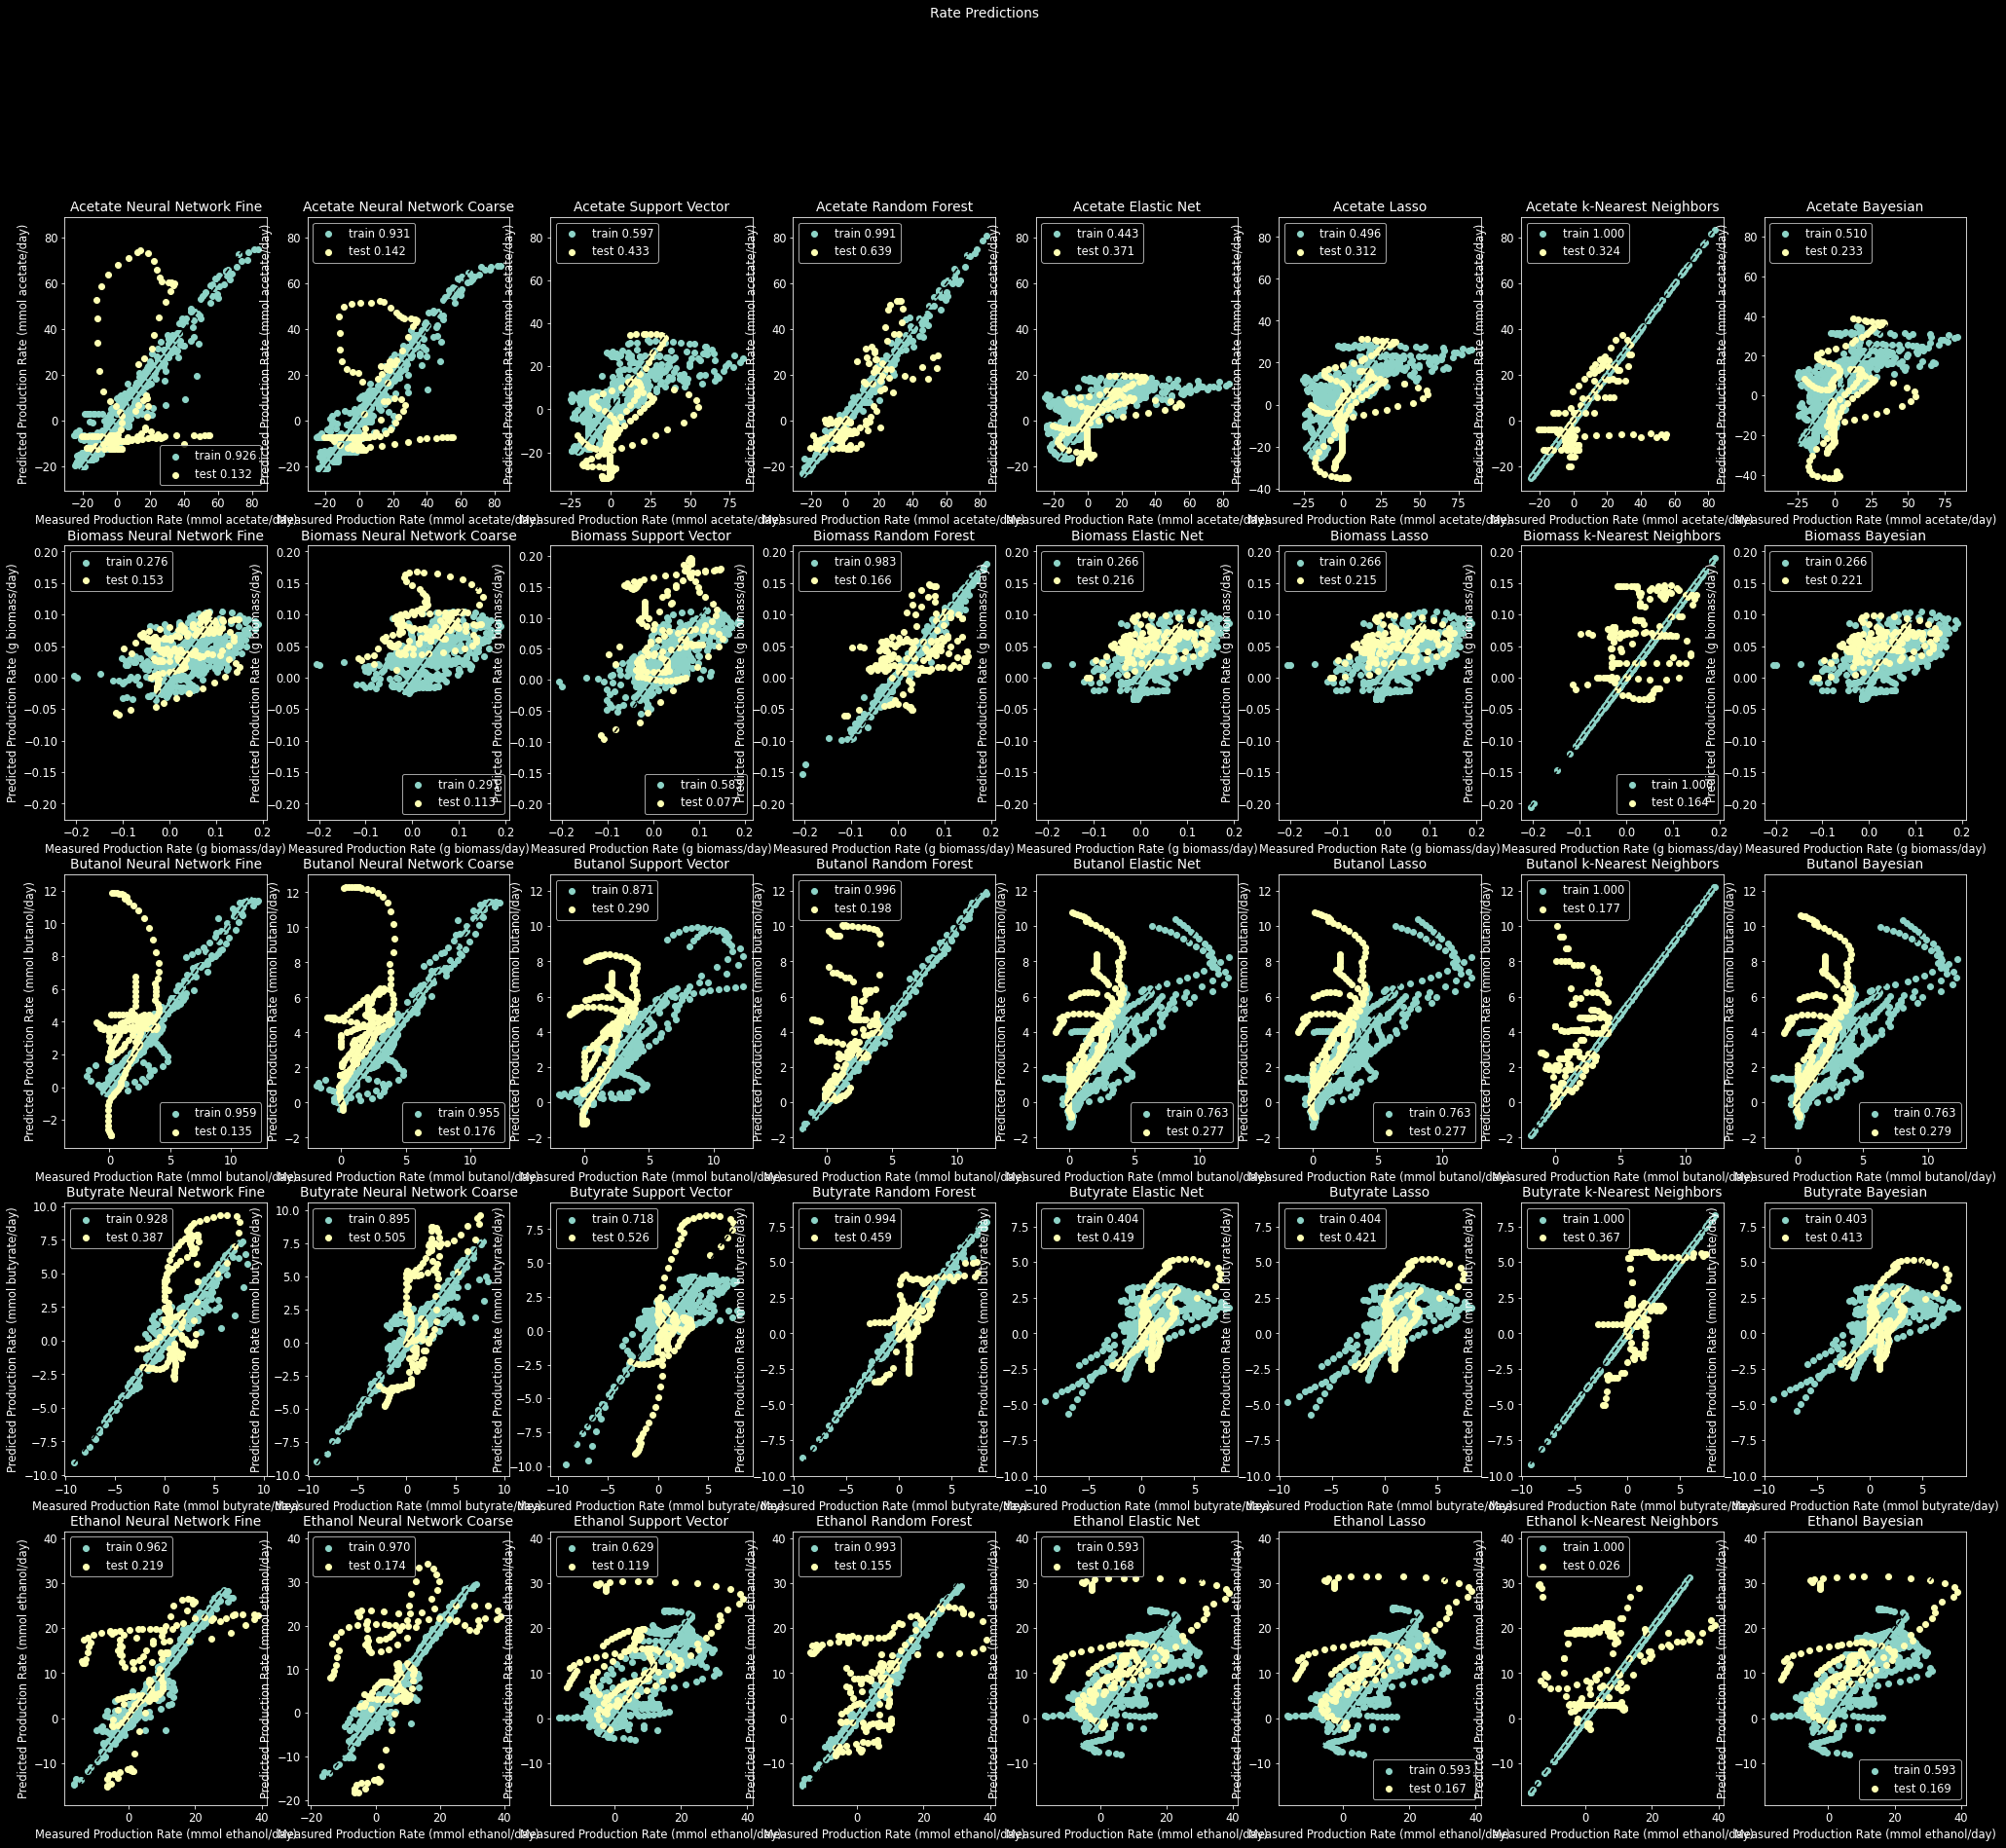

In [16]:
plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(5, 8, figsize=(35, 30))
fig.suptitle(f'Rate Predictions')

algorithm_dictionary = {
    'nn_fine': 'Neural Network Fine',
    'nn_coarse': 'Neural Network Coarse',
    'svm_rbf': 'Support Vector', 
    'rf' : 'Random Forest',
    'en': 'Elastic Net', 
    'lasso' : 'Lasso',
    'knn': 'k-Nearest Neighbors',
    'bayesian': 'Bayesian',
}

for x_index, output in enumerate(['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']):
    train_r2_list = []
    test_r2_list = []
    for y_index, algorithm in enumerate(['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn', 'bayesian']):
 
        # Set title, x label, and y label of the subplot
        ax[x_index, y_index].title.set_text(f'{output.capitalize()} {algorithm_dictionary[algorithm]}')
        if output != 'biomass':
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (mmol {output}/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (mmol {output}/day)')
        else:
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (g biomass/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (g biomass/day)')
            
        # Plot training and test data by plotting predicted Production Rates vs measured Production Rates
        ax[x_index, y_index].scatter(train_prediction_df[f'{output} measured'], train_prediction_df[f'{output} {algorithm}'])
        ax[x_index, y_index].scatter(test_prediction_df[f'{output} measured'], test_prediction_df[f'{output} {algorithm}'])
        
        # ensure that all plots are square, so that 45 degree line looks the same in all plots
        minimum = min(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        maximum = max(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        
        # calculate train data r-squared
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # train_r2 = sklearn.metrics.r2_score(measured_train_data, predicted_train_data)
        _, _, train_r_value, _, _ = scipy.stats.linregress(measured_train_data, predicted_train_data)
        train_r2_list.append(train_r_value**2)

        # calculate test data r-squared
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        # could use scikitlearn's r-squared value
        # test_r2 = sklearn.metrics.r2_score(measured_test_data, predicted_test_data)
        _, _, test_r_value, _, _ = scipy.stats.linregress(measured_test_data, predicted_test_data)
        test_r2_list.append(test_r_value**2)
        
        # add legend to the plot
        ax[x_index, y_index].legend([f'train {train_r_value**2:.3f}', f'test {test_r_value**2:.3f}'])
        
        # plot the subplot
        ax[x_index, y_index].plot([minimum, maximum], [minimum, maximum], 'k--') #row=0, col=0

plt.savefig(f'../figures/scatter_plots_r2.png', dpi=100)
plt.show()

### Plot scatter plots of fits (RMSE)

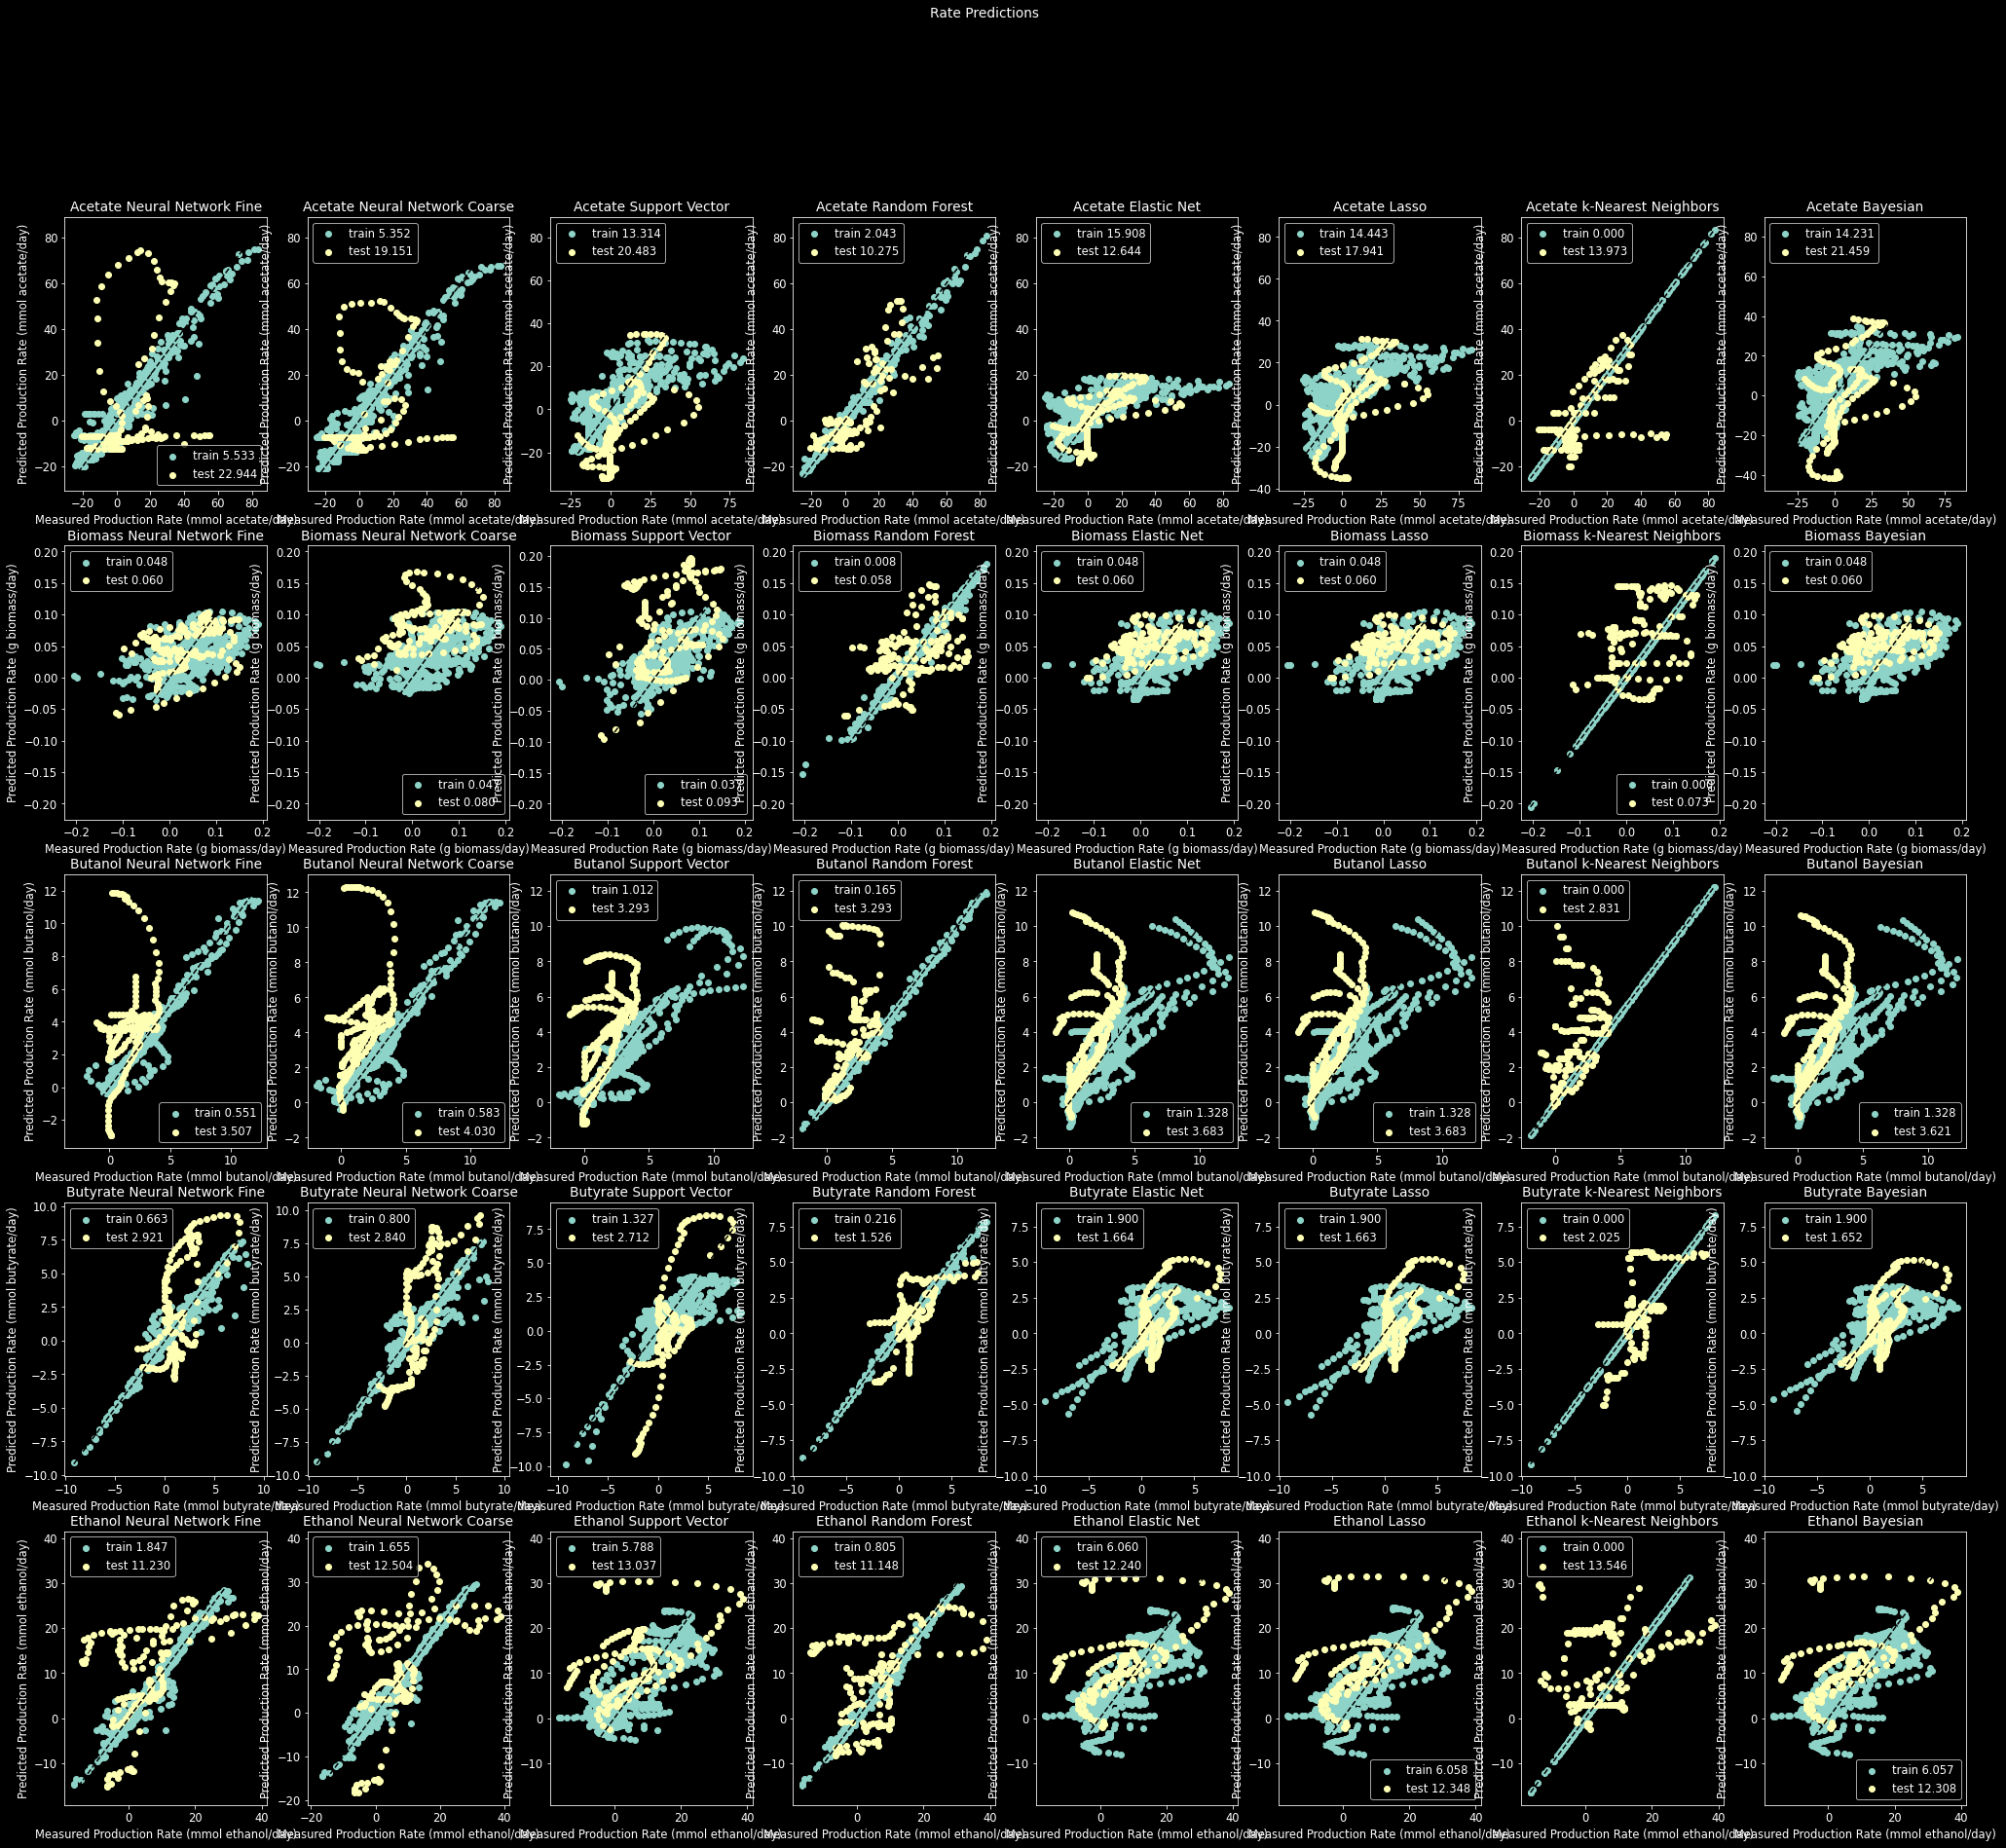

In [15]:
plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(5, 8, figsize=(35, 30))
fig.suptitle(f'Rate Predictions')

algorithm_dictionary = {
    'nn_fine': 'Neural Network Fine',
    'nn_coarse': 'Neural Network Coarse',
    'svm_rbf': 'Support Vector', 
    'rf' : 'Random Forest',
    'en': 'Elastic Net', 
    'lasso' : 'Lasso',
    'knn': 'k-Nearest Neighbors',
    'bayesian': 'Bayesian'
}

for x_index, output in enumerate(['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']):
    train_rmse_list = []
    test_rmse_list = []
    for y_index, algorithm in enumerate(['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn', 'bayesian']):
 
        # Set title, x label, and y label of the subplot
        ax[x_index, y_index].title.set_text(f'{output.capitalize()} {algorithm_dictionary[algorithm]}')
        if output != 'biomass':
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (mmol {output}/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (mmol {output}/day)')
        else:
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (g biomass/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (g biomass/day)')
            
        # Plot training and test data by plotting predicted Production Rates vs measured Production Rates
        ax[x_index, y_index].scatter(train_prediction_df[f'{output} measured'], train_prediction_df[f'{output} {algorithm}'])
        ax[x_index, y_index].scatter(test_prediction_df[f'{output} measured'], test_prediction_df[f'{output} {algorithm}'])
        
        # ensure that all plots are square, so that 45 degree line looks the same in all plots
        minimum = min(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        maximum = max(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        
        # calculate train data rmse
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        train_rmse_value = sklearn.metrics.mean_squared_error(measured_train_data, predicted_train_data, squared=False)
        train_rmse_list.append(train_rmse_value)

        # calculate test data rmse
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        test_rmse_value = sklearn.metrics.mean_squared_error(measured_test_data, predicted_test_data, squared=False)
        test_rmse_list.append(test_rmse_value)
        
        # add legend to the plot
        ax[x_index, y_index].legend([f'train {train_rmse_value:.3f}', f'test {test_rmse_value:.3f}'])
        
        # plot the subplot
        ax[x_index, y_index].plot([minimum, maximum], [minimum, maximum], 'k--') #row=0, col=0

plt.savefig(f'../figures/scatter_plots_rmse.png', dpi=100)
plt.show()

### Plot scatter plots of fits (MAPE)

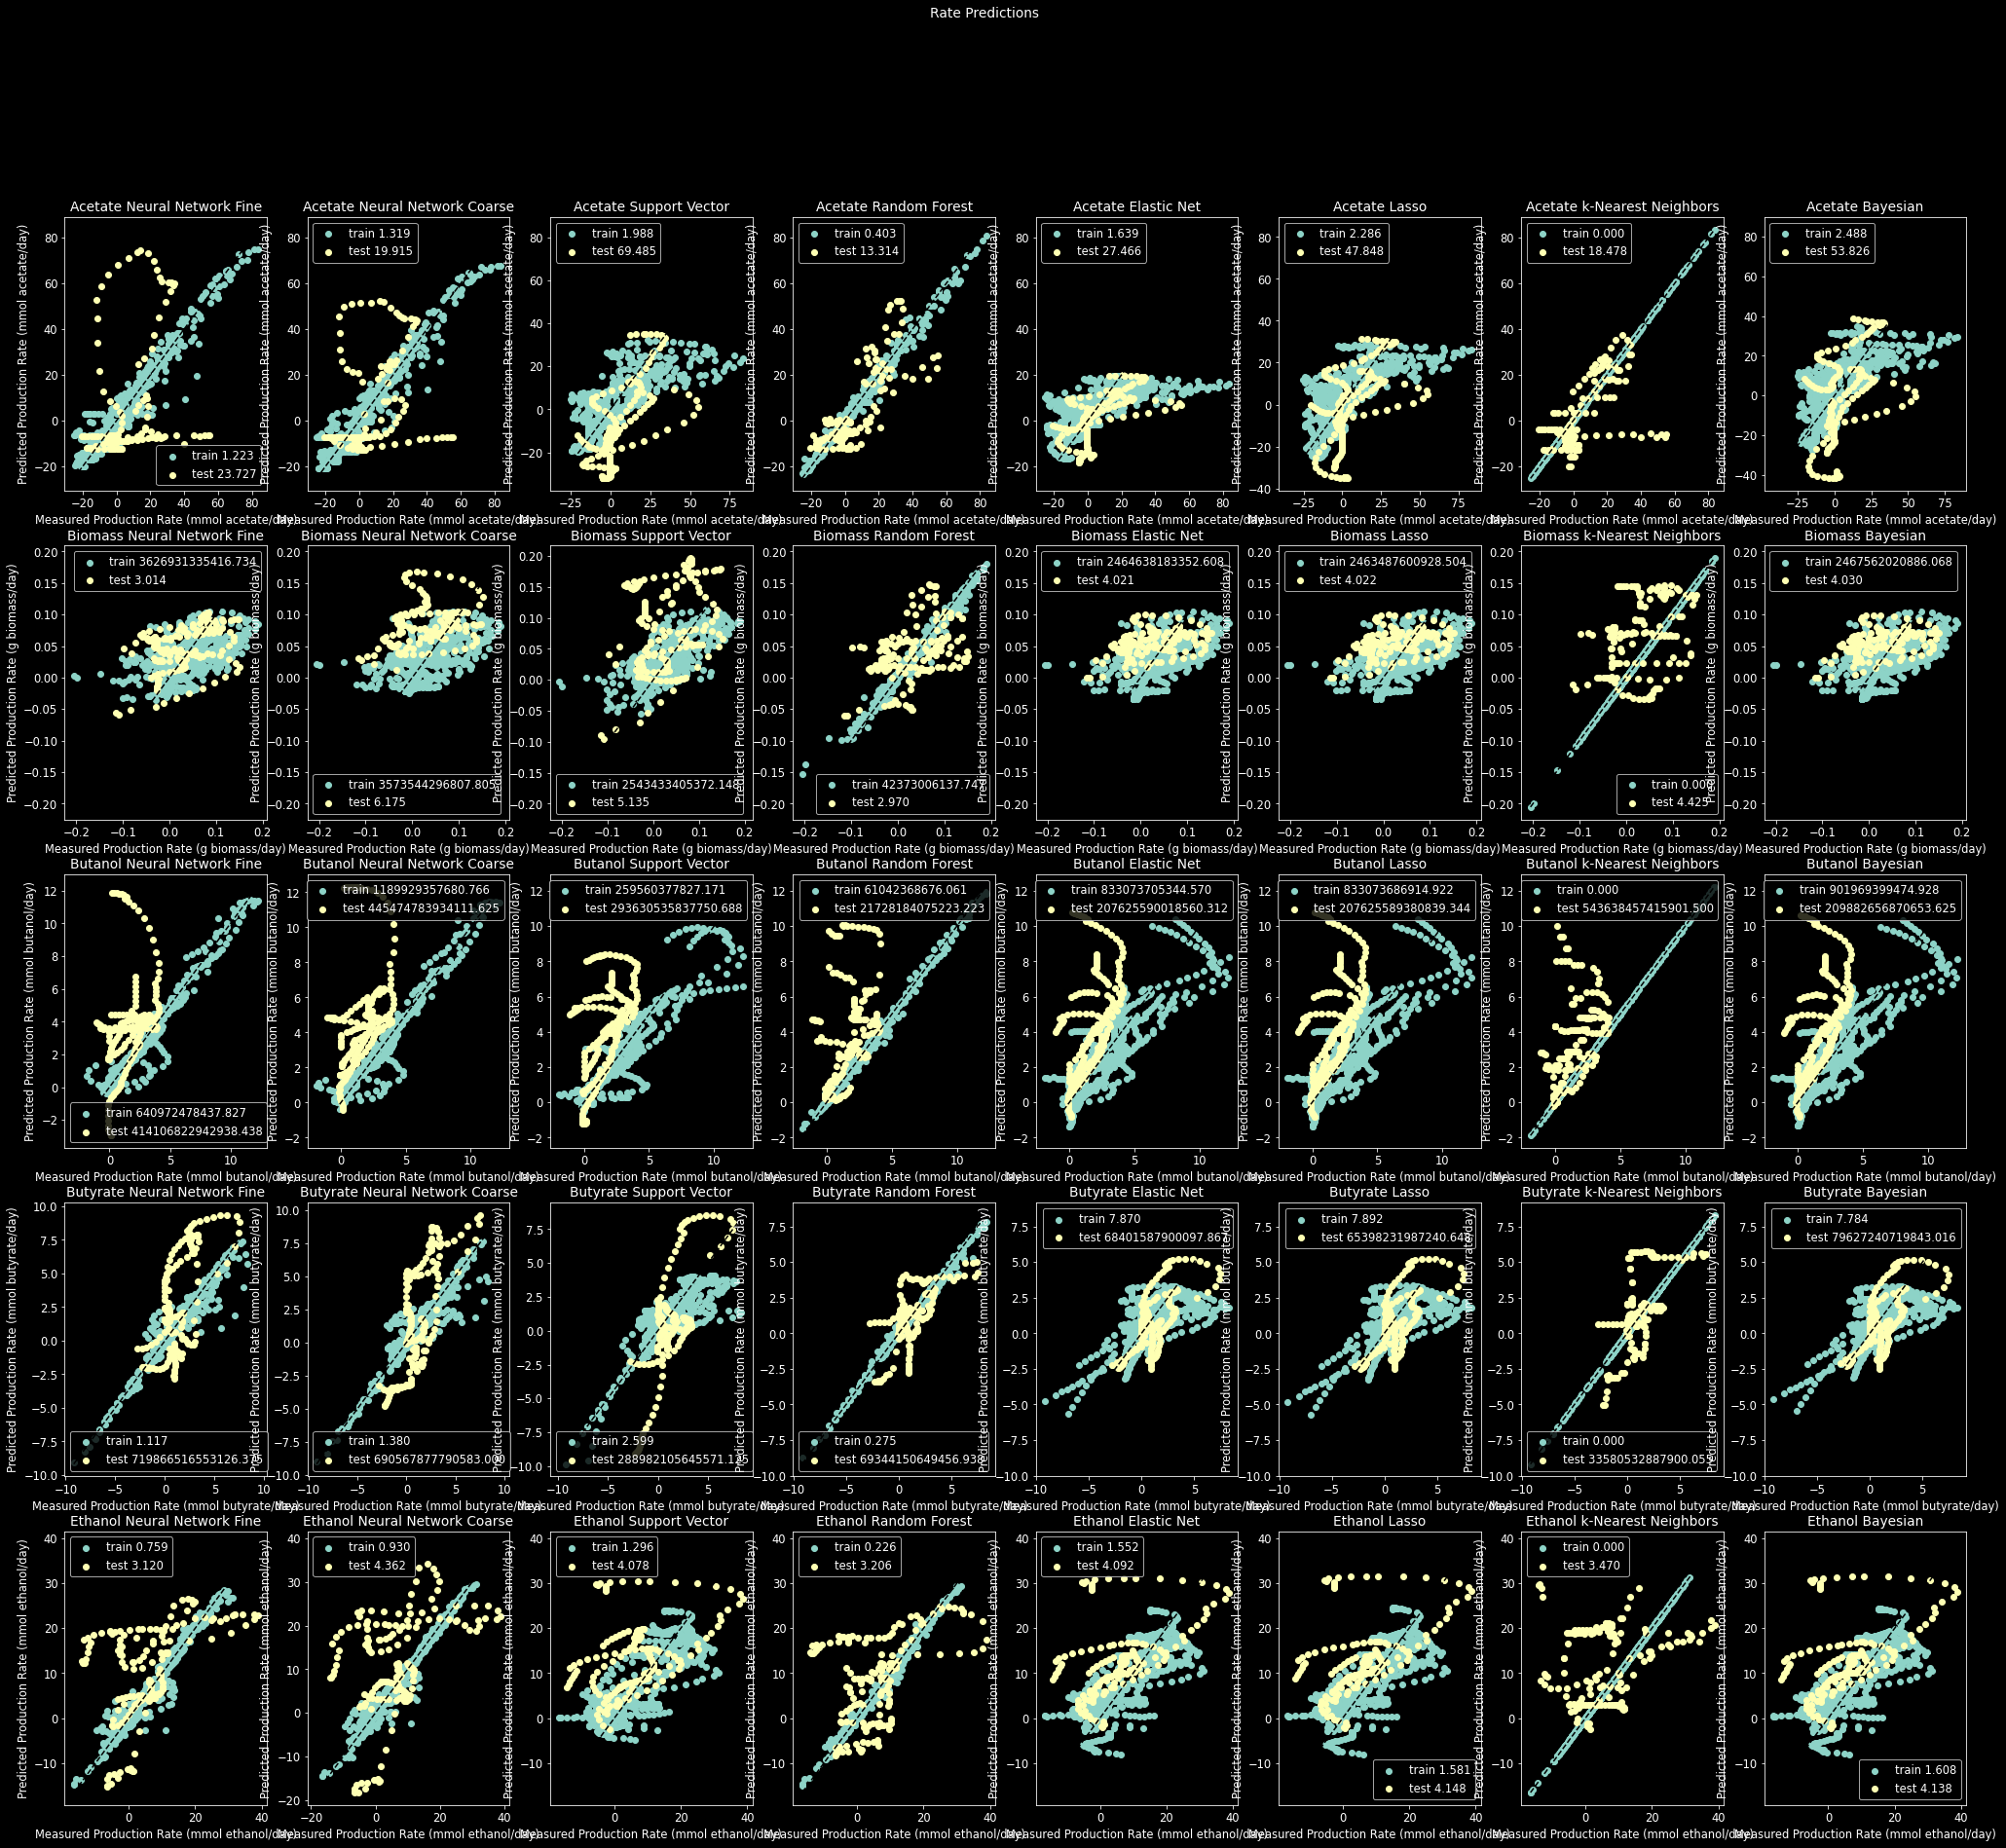

In [17]:
plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(5, 8, figsize=(35, 30))
fig.suptitle(f'Rate Predictions')

algorithm_dictionary = {
    'nn_fine': 'Neural Network Fine',
    'nn_coarse': 'Neural Network Coarse',
    'svm_rbf': 'Support Vector', 
    'rf' : 'Random Forest',
    'en': 'Elastic Net', 
    'lasso' : 'Lasso',
    'knn': 'k-Nearest Neighbors',
    'bayesian': 'Bayesian'
}

for x_index, output in enumerate(['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']):
    train_mape_list = []
    test_mape_list = []
    for y_index, algorithm in enumerate(['nn_fine', 'nn_coarse', 'svm_rbf', 'rf', 'en', 'lasso', 'knn', 'bayesian']):
 
        # Set title, x label, and y label of the subplot
        ax[x_index, y_index].title.set_text(f'{output.capitalize()} {algorithm_dictionary[algorithm]}')
        if output != 'biomass':
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (mmol {output}/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (mmol {output}/day)')
        else:
            ax[x_index, y_index].set_xlabel(f'Measured Production Rate (g biomass/day)')
            ax[x_index, y_index].set_ylabel(f'Predicted Production Rate (g biomass/day)')
            
        # Plot training and test data by plotting predicted Production Rates vs measured Production Rates
        ax[x_index, y_index].scatter(train_prediction_df[f'{output} measured'], train_prediction_df[f'{output} {algorithm}'])
        ax[x_index, y_index].scatter(test_prediction_df[f'{output} measured'], test_prediction_df[f'{output} {algorithm}'])
        
        # ensure that all plots are square, so that 45 degree line looks the same in all plots
        minimum = min(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        maximum = max(pd.concat([
            train_prediction_df[f'{output} measured'],
            train_prediction_df[f'{output} {algorithm}'],
            test_prediction_df[f'{output} measured'],
            test_prediction_df[f'{output} {algorithm}']
        ], axis=0))
        
        # calculate train data mape
        measured_train_data = train_prediction_df[f'{output} measured']
        predicted_train_data = train_prediction_df[f'{output} {algorithm}']
        train_mape_value = sklearn.metrics.mean_absolute_percentage_error(measured_train_data, predicted_train_data)
        train_mape_list.append(train_mape_value)

        # calculate test data mape
        measured_test_data = test_prediction_df[f'{output} measured']
        predicted_test_data = test_prediction_df[f'{output} {algorithm}']
        test_mape_value = sklearn.metrics.mean_absolute_percentage_error(measured_test_data, predicted_test_data)
        test_mape_list.append(test_mape_value)
        
        # add legend to the plot
        ax[x_index, y_index].legend([f'train {train_mape_value:.3f}', f'test {test_mape_value:.3f}'])
        
        # plot the subplot
        ax[x_index, y_index].plot([minimum, maximum], [minimum, maximum], 'k--') #row=0, col=0

plt.savefig(f'../figures/scatter_plots_mape.png', dpi=100)
plt.show()

### Make data frames to plot feature importance of metabolite and gases

In [18]:
features = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol', 'CO', 'CO2', 'H2', 'flow rate']

metabolites = ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']
gases = ['CO', 'CO2', 'H2', 'flow rate']

metabolite_feature_importance_list = []
gases_feature_importance_list = []

for output in ['acetate', 'biomass', 'butanol', 'butyrate', 'ethanol']:
    
    # get trained random forest model for the output
    model = trained_models[f'{output} rf']
    
    # get feature importance
    feature_importance_array = model.feature_importances_
    # print(feature_importance_array)
    
    # label feature importances
    feature_importance_dictionary = {feature: importance for feature, importance in zip(features, feature_importance_array)}
    
    # split dictionary into metabolites and gases and add the split dictionaries to lists
    metabolite_feature_importance_list.append({metabolite: feature_importance_dictionary[metabolite] for metabolite in metabolites})
    gases_feature_importance_list.append({gas: feature_importance_dictionary[gas] for gas in gases})
    
# convert list of dictionaries to dataframes
metabolite_feature_importance_df = pd.DataFrame(metabolite_feature_importance_list, index=metabolites)
gases_feature_importance_df = pd.DataFrame(gases_feature_importance_list, index=metabolites)

# display the dataframes
display(metabolite_feature_importance_df)
display(gases_feature_importance_df)


,acetate,biomass,butanol,butyrate,ethanol
acetate,0.038743,0.056555,0.133280,0.612357,0.107462
biomass,0.161170,0.140164,0.249923,0.236367,0.120039
butanol,0.049151,0.144739,0.029787,0.588873,0.050639
butyrate,0.122146,0.101123,0.133775,0.369814,0.169861
ethanol,0.041218,0.646695,0.067063,0.095281,0.101379


,CO,CO2,H2,flow rate
acetate,0.002198,0.012518,0.002577,0.009944
biomass,0.010512,0.009644,0.015882,0.012827
butanol,0.002354,0.002810,0.100623,0.020277
butyrate,0.091786,0.002317,0.002280,0.003468
ethanol,0.005121,0.006199,0.003100,0.007709


### Plot metabolite feature importance

,acetate,biomass,butanol,butyrate,ethanol
acetate,0.038743,0.056555,0.133280,0.612357,0.107462
biomass,0.161170,0.140164,0.249923,0.236367,0.120039
butanol,0.049151,0.144739,0.029787,0.588873,0.050639
butyrate,0.122146,0.101123,0.133775,0.369814,0.169861
ethanol,0.041218,0.646695,0.067063,0.095281,0.101379


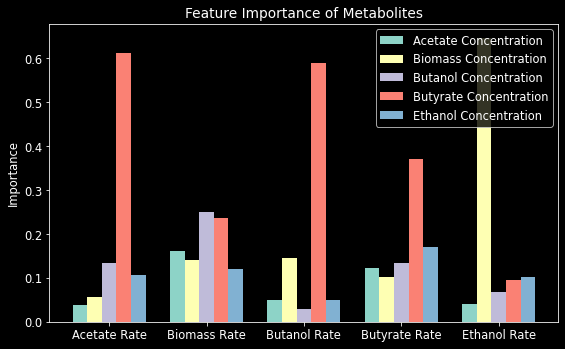

In [19]:
display(metabolite_feature_importance_df)

# This helps with formatting 
x = np.arange(5)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for counter, (index, row) in enumerate(metabolite_feature_importance_df.transpose().iterrows()):
    output_feature_importances = list(row)
    
    rects = ax.bar(x - 0.3 + 0.15*counter, output_feature_importances , width, label=f'{index.capitalize()} Concentration')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'Importance')

ax.set_title(f'Feature Importance of Metabolites')
ax.set_xticks(x)
labels = ['Acetate Rate', 'Biomass Rate', 'Butanol Rate', 'Butyrate Rate', 'Ethanol Rate']
ax.set_xticklabels(labels)
ax.legend()
# ax.set_yscale('log')

fig.tight_layout()
plt.savefig(f'../figures/feature_importance_metabolites.png', dpi=100)
plt.show()

### Plot gases feature importance

,CO,CO2,H2,flow rate
acetate,0.002198,0.012518,0.002577,0.009944
biomass,0.010512,0.009644,0.015882,0.012827
butanol,0.002354,0.002810,0.100623,0.020277
butyrate,0.091786,0.002317,0.002280,0.003468
ethanol,0.005121,0.006199,0.003100,0.007709


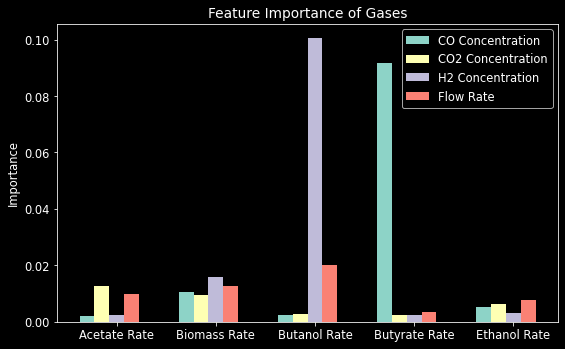

In [20]:
display(gases_feature_importance_df)

# This helps with formatting 
x = np.arange(5)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(figsize=(8,5))

for counter, (index, row) in enumerate(gases_feature_importance_df.transpose().iterrows()):
    output_feature_importances = list(row)
    if index != 'flow rate':
        index = index + ' Concentration' 
    else:
        index = 'Flow Rate'
    rects = ax.bar(x - 0.3 + 0.15*counter, output_feature_importances , width, label=f'{index}')

# # Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel(f'Importance')

ax.set_title(f'Feature Importance of Gases')
ax.set_xticks(x)
labels = ['Acetate Rate', 'Biomass Rate', 'Butanol Rate', 'Butyrate Rate', 'Ethanol Rate']
ax.set_xticklabels(labels)
ax.legend()
# ax.set_yscale('log')

fig.tight_layout()
plt.savefig(f'../figures/feature_importance_gases.png', dpi=100)
plt.show()

### Plot feature importance of each gas for each output

,CO,CO2,H2,flow rate
acetate,0.002198,0.012518,0.002577,0.009944
biomass,0.010512,0.009644,0.015882,0.012827
butanol,0.002354,0.002810,0.100623,0.020277
butyrate,0.091786,0.002317,0.002280,0.003468
ethanol,0.005121,0.006199,0.003100,0.007709


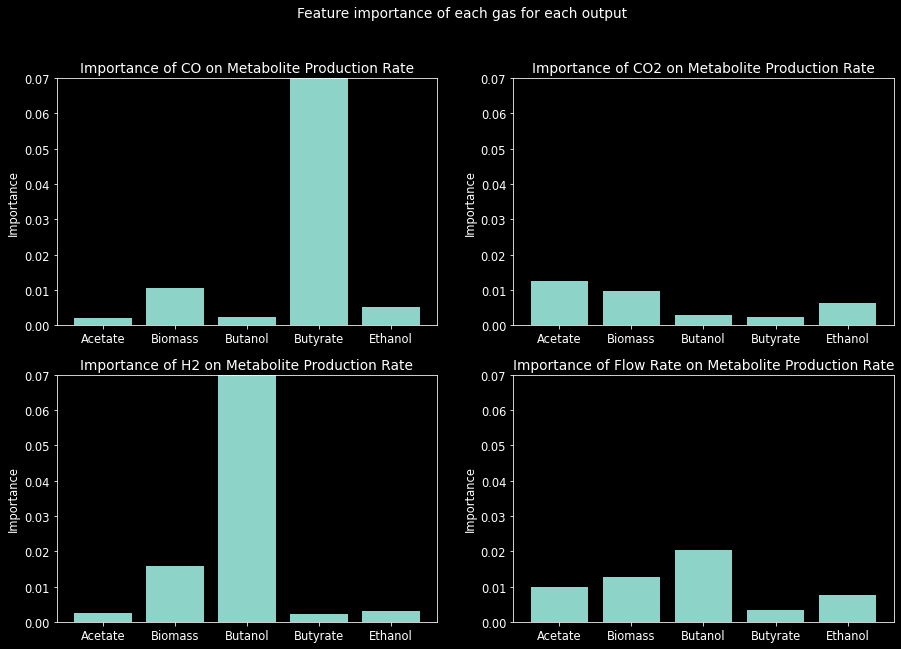

In [21]:
display(gases_feature_importance_df)

plt.rcParams.update({'font.size': 11.5})
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Feature importance of each gas for each output')

labels = [label.capitalize() for label in gases_feature_importance_df.index]

ax[0,0].title.set_text(f'Importance of CO on Metabolite Production Rate')
ax[0,0].set_ylabel(f'Importance')
ax[0,0].axis(ymin=0.0,ymax=0.07)
rects = ax[0,0].bar(labels, gases_feature_importance_df['CO'])

ax[0,1].title.set_text(f'Importance of CO2 on Metabolite Production Rate')
ax[0,1].set_ylabel(f'Importance')
ax[0,1].axis(ymin=0.0,ymax=0.07)
rects = ax[0,1].bar(labels, gases_feature_importance_df['CO2'])

ax[1,0].title.set_text(f'Importance of H2 on Metabolite Production Rate')
ax[1,0].set_ylabel(f'Importance')
ax[1,0].axis(ymin=0.0,ymax=0.07)
rects = ax[1,0].bar(labels, gases_feature_importance_df['H2'])

ax[1,1].title.set_text(f'Importance of Flow Rate on Metabolite Production Rate')
ax[1,1].set_ylabel(f'Importance')
ax[1,1].axis(ymin=0.0,ymax=0.07)
rects = ax[1,1].bar(labels, gases_feature_importance_df['flow rate'])

plt.savefig(f'../figures/feature_importance_per_gas.png', dpi=100)

plt.show()

### Save gases_feature_importance as csv

In [22]:
gases_feature_importance_df.to_csv('../data/gases_importance.csv')

### -- Stopping here --